In [1]:
%cd 'all_data'

/Users/simranmasand/Downloads/all_data


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
# from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm
from PIL import Image    
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [15]:
image_folder = 'train/images' #path to folder containing images
# total_images = len(os.listdir(image_folder))
# print('The number of images in data are: %i'%(total_images))

<Figure size 432x288 with 0 Axes>

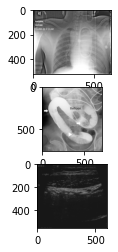

In [8]:
#showing random 3 sample images
np.random.seed(420)
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,1) 
window_name = 'image'
for i in range(3): #print 3 sample images
    k = np.random.choice(range(total_images))
    image_file = os.listdir(image_folder)[k]
    image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
    axarr[i].imshow(image)  
#     print("\t\t",image_file) #the image file name

In [5]:
# cap_train.to_pickle("total_data.pkl")

In [3]:
cap_train = pd.read_pickle("total_data.pkl")

# Tokenizing data

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [5]:
cap_train["caption_final"] = ' '+cap_train.caption + ' '
cap_train["caption_ip"] = ' ' + cap_train.caption
cap_train["caption_op"] = cap_train.caption + ' '
cap_train.head()

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
0,Computed tomography scan in axial view showin...,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,704,704,1,Computed tomography scan in axial view showi...,Computed tomography scan in axial view showi...,Computed tomography scan in axial view showin...
1,Bacterial contamination occurred after comple...,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,763,745,1,Bacterial contamination occurred after compl...,Bacterial contamination occurred after compl...,Bacterial contamination occurred after comple...
2,The patient had residual paralysis of the han...,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,1258,737,1,The patient had residual paralysis of the ha...,The patient had residual paralysis of the ha...,The patient had residual paralysis of the han...
3,Panoramic radiograph after immediate loading.\n,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,325,600,1,Panoramic radiograph after immediate loading...,Panoramic radiograph after immediate loading.\n,Panoramic radiograph after immediate loading.\n
4,Plain abdomen x-ray: Multiple air levels at t...,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,499,600,1,Plain abdomen x-ray: Multiple air levels at ...,Plain abdomen x-ray: Multiple air levels at ...,Plain abdomen x-ray: Multiple air levels at t...


In [6]:
cap_train.drop_duplicates(subset=['caption'],inplace=True)

In [7]:
cap_train.shape

(64772, 9)

In [8]:
cap_train.sort_values(by='caption_y',ascending=False)

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
2314,Initial panoramic radiograph.\n,ROCO_02908,PMC4347419_dpjo-19-06-00113-gf04.jpg,364,755,19,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n
4756,Preoperative radiograph\n,ROCO_05953,PMC4213876_IJD-5-161-g001.jpg,538,447,15,Preoperative radiograph\n,Preoperative radiograph\n,Preoperative radiograph\n
1223,Postoperative radiograph\n,ROCO_01527,PMC4922229_NJMS-6-180-g006.jpg,587,734,13,Postoperative radiograph\n,Postoperative radiograph\n,Postoperative radiograph\n
6269,Chest X-ray\n,ROCO_07832,PMC2700453_ATM-03-158-g001.jpg,559,743,11,Chest X-ray\n,Chest X-ray\n,Chest X-ray\n
5159,Final panoramic radiograph.\n,ROCO_06465,PMC4944735_2176-9451-dpjo-21-03-00104-gf8.jpg,239,519,11,Final panoramic radiograph.\n,Final panoramic radiograph.\n,Final panoramic radiograph.\n
...,...,...,...,...,...,...,...,...,...
21873,Computed tomographic scan of the abdomen and ...,ROCO_27270,PMC3041052_jls0031026500001.jpg,254,406,1,Computed tomographic scan of the abdomen and...,Computed tomographic scan of the abdomen and...,Computed tomographic scan of the abdomen and ...
21874,Computed tomography scan at the level of the ...,ROCO_27271,PMC2657771_1757-7241-17-5-3.jpg,512,512,1,Computed tomography scan at the level of the...,Computed tomography scan at the level of the...,Computed tomography scan at the level of the ...
21875,Magnetic resonance imaging of the mass\n,ROCO_27272,PMC5558406_TJOD-12-53-g1.jpg,568,450,1,Magnetic resonance imaging of the mass\n,Magnetic resonance imaging of the mass\n,Magnetic resonance imaging of the mass\n
21876,Computed tomography image of the abdominal ao...,ROCO_27273,PMC4928836_pone.0158042.g002.jpg,484,700,1,Computed tomography image of the abdominal a...,Computed tomography image of the abdominal a...,Computed tomography image of the abdominal ao...


In [9]:
cap_train[cap_train['caption_y']>5]

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
412,Chest radiograph.\n,ROCO_00520,PMC4666442_EDU-0012-2015.01.jpg,634,779,9,Chest radiograph.\n,Chest radiograph.\n,Chest radiograph.\n
1223,Postoperative radiograph\n,ROCO_01527,PMC4922229_NJMS-6-180-g006.jpg,587,734,13,Postoperative radiograph\n,Postoperative radiograph\n,Postoperative radiograph\n
1318,Preoperative panoramic radiograph.\n,ROCO_01658,PMC4331475_CRID2015-267625.001.jpg,575,750,6,Preoperative panoramic radiograph.\n,Preoperative panoramic radiograph.\n,Preoperative panoramic radiograph.\n
1685,Chest X-ray on admission.\n,ROCO_02126,PMC2804722_1757-1626-2-9333-1.jpg,491,600,6,Chest X-ray on admission.\n,Chest X-ray on admission.\n,Chest X-ray on admission.\n
2156,Immediate postoperative radiograph\n,ROCO_02711,PMC4178361_NJMS-5-67-g001.jpg,525,785,6,Immediate postoperative radiograph\n,Immediate postoperative radiograph\n,Immediate postoperative radiograph\n
2314,Initial panoramic radiograph.\n,ROCO_02908,PMC4347419_dpjo-19-06-00113-gf04.jpg,364,755,19,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n
3326,Coronal CT scan of the patient.\n,ROCO_04146,PMC3793112_arh0021200560003.jpg,634,656,7,Coronal CT scan of the patient.\n,Coronal CT scan of the patient.\n,Coronal CT scan of the patient.\n
3547,Abdominal X-ray.\n,ROCO_04432,PMC3234154_ijnrd-4-137f1.jpg,329,406,6,Abdominal X-ray.\n,Abdominal X-ray.\n,Abdominal X-ray.\n
4756,Preoperative radiograph\n,ROCO_05953,PMC4213876_IJD-5-161-g001.jpg,538,447,15,Preoperative radiograph\n,Preoperative radiograph\n,Preoperative radiograph\n
5159,Final panoramic radiograph.\n,ROCO_06465,PMC4944735_2176-9451-dpjo-21-03-00104-gf8.jpg,239,519,11,Final panoramic radiograph.\n,Final panoramic radiograph.\n,Final panoramic radiograph.\n


In [10]:
# train.to_pickle('train.pkl')
# test.to_pickle('test.pkl')

In [11]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

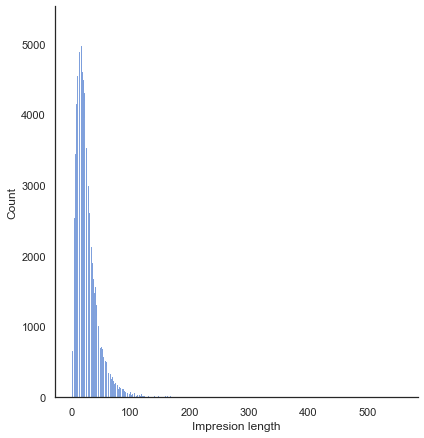


Value Counts for caption length top 5 values

Length|Counts
16    5266
13    5166
15    5147
17    5130
18    4963
dtype: int64

The max and min value of "caption length" was found to be 557 and 1 respectively
The 80 percentile value of caption_len which is 37 will be taken as the maximum padded value for each impression


In [12]:
#tokenizer
tokenizer = Tokenizer(filters = '/n',oov_token = '') #setting filters to none
tokenizer.fit_on_texts(train.caption_final.values)
train_captions = tokenizer.texts_to_sequences(train.caption_final) 
test_captions = tokenizer.texts_to_sequences(test.caption_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index[''] #tokened value of 
end_index = tokenizer.word_index[''] #tokened value of 


#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader
     

# Setting up training schedules

In [17]:
batch_size = 100
embedding_dim = 300
dense_dim = (400,600)
lstm_units = dense_dim
dropout_rate = 0.2

In [65]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
    def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
        """
        df  = dataframe containing image_1,image_2 and impression
        """
        self.image1 = df.name
        self.caption = df.caption_ip #inp
        self.caption1 = df.caption_op  #output;
        self.input_size = input_size #tuple ex: (512,512) aiming for 400,600; though 512x512 shall work too
        self.tokenizer = tokenizer
        self.augmentation = augmentation
        self.max_pad = max_pad

        #image augmentation
        #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
        self.aug1 = iaa.Fliplr(1) #flip images horizaontally
        self.aug2 = iaa.Flipud(1) #flip images vertically


    def __getitem__(self,i):
        #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
        image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
        image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
        if image1.any()==None:
            print("%i , %s image sent null value"%(i,self.image1[i]))


        #tokenizing and padding
        caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
        caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

        caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
        caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




        if self.augmentation: #we will not apply augmentation that crops the image 
            a = np.random.uniform()
            if a<0.333:
                image1 = self.aug1.augment_image(image1)
            elif a<0.667:
                image1 = self.aug2.augment_image(image1)
            else: #applying no augmentation
                pass;


        return image1,caption,caption1

    
    def __len__(self):
        return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]]]) #here [image1,image2, caption(without )],caption(without ) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [66]:
input_size = (400,600)
train_dataloader = Dataset(train,input_size)
# train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

# test_dataloader = Dataset(test,input_size)
# test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)


In [39]:
import torch
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel


In [40]:
torch.__version__

'2.1.0.dev20230602'

In [3]:

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [13]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))


a photography of a woman and her dog on the beach
a woman sitting on the beach with her dog


 Sagittal T1-weighted magnetic resonance image four weeks after the endoscopic third ventriculostomy. Demonstrates unchanged ventricular size despite patent ventriculostomy



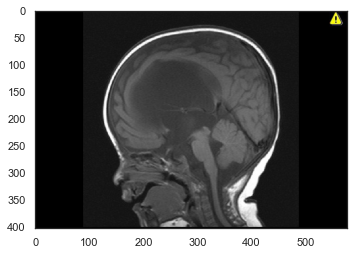

In [16]:
print(train.iloc[0]["caption"])

plt.imshow(plt.imread(image_folder+"/"+train.iloc[0]["name"]))

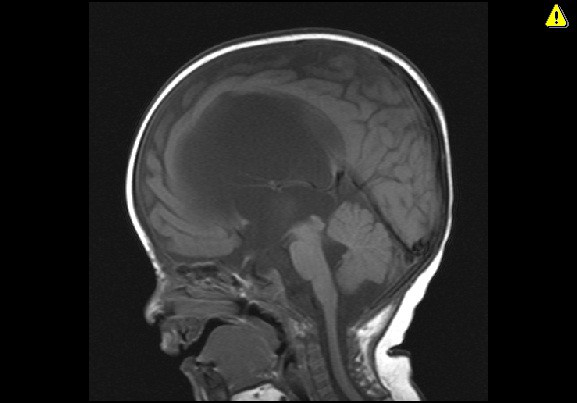

In [17]:
image_ex = Image.open(image_folder+"/"+train.iloc[0]["name"])
image_ex
# model.encode_image(image = Image.open(image_folder+"/"+train.iloc[0]["name"]))

In [18]:
inputs = processor(image_ex, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

the brain is shown in this mri mri mri mri mri mri mri mri mri mri mri mri mri


In [46]:
train

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
0,Sagittal T1-weighted magnetic resonance image...,ROCO_17530,PMC3443652_1752-1947-6-222-2.jpg,403,577,1,Sagittal T1-weighted magnetic resonance imag...,Sagittal T1-weighted magnetic resonance imag...,Sagittal T1-weighted magnetic resonance image...
1,Computed tomography scan demonstrating a righ...,ROCO_33013,PMC4298933_LI-32-87-g001.jpg,463,576,1,Computed tomography scan demonstrating a rig...,Computed tomography scan demonstrating a rig...,Computed tomography scan demonstrating a righ...
2,Computed tomographic angiogram of the patient...,ROCO_74213,PMC4887620_CRIS2016-1375214.003.jpg,867,519,1,Computed tomographic angiogram of the patien...,Computed tomographic angiogram of the patien...,Computed tomographic angiogram of the patient...
3,An intact 26-month graft.\n,ROCO_01928,PMC4186304_gox-1-e76-g010.jpg,1156,800,1,An intact 26-month graft.\n,An intact 26-month graft.\n,An intact 26-month graft.\n
4,Real time MR temperature monitoring in the ab...,ROCO_16297,PMC4250033_poljradiol-79-439-g002.jpg,573,600,1,Real time MR temperature monitoring in the a...,Real time MR temperature monitoring in the a...,Real time MR temperature monitoring in the ab...
...,...,...,...,...,...,...,...,...,...
155405,Panorex view of the mandible\n,ROCO_38974,PMC4090976_JSTCR-6-21-g003.jpg,306,555,1,Panorex view of the mandible\n,Panorex view of the mandible\n,Panorex view of the mandible\n
155406,Imaging characteristics from lung CT. A 46-ye...,ROCO_21082,PMC5463395_13054_2017_1731_Fig1_HTML.jpg,264,358,1,Imaging characteristics from lung CT. A 46-y...,Imaging characteristics from lung CT. A 46-y...,Imaging characteristics from lung CT. A 46-ye...
155407,Follow-up panoramic radiograph depicting erup...,ROCO_58556,PMC4771879_CRID2016-9750947.009.jpg,402,750,1,Follow-up panoramic radiograph depicting eru...,Follow-up panoramic radiograph depicting eru...,Follow-up panoramic radiograph depicting erup...
155408,Radiographs show healing of the fracture at 5...,ROCO_00459,PMC4109381_1471-2474-15-225-4.jpg,751,600,1,Radiographs show healing of the fracture at ...,Radiographs show healing of the fracture at ...,Radiographs show healing of the fracture at 5...


In [19]:
from datasets import load_dataset
from datasets import load_from_disk

In [20]:
train_data = load_from_disk('datasets/train')

In [21]:
train_data

Dataset({
    features: ['image', 'Unnamed: 0', 'id', 'caption'],
    num_rows: 65419
})

In [28]:
val_data = load_from_disk('datasets/val')
test_data = load_from_disk('datasets/test')

In [22]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [24]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [25]:
train_dataset = ImageCaptioningDataset(train_data, processor)

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)

In [29]:
val_dataset = ImageCaptioningDataset(val_data["train"], processor)

In [30]:
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1)

In [31]:
test_dataset = ImageCaptioningDataset(test_data["train"], processor)

In [32]:
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=2)

In [33]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 384, 384])
input_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])


In [34]:
processor.decode(batch["input_ids"][0])

'[CLS] frog leg lateral x - ray of bilateral hips again showing avascular changes with characteristic “ crescent sign ” of osteonecrosis to right femoral head. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

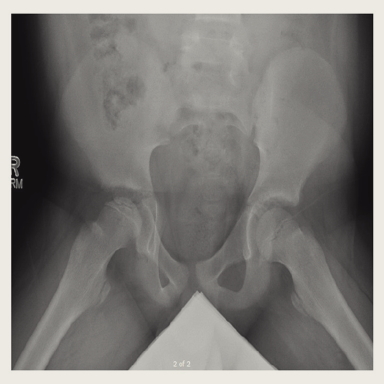

In [35]:
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [36]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(13.1715, grad_fn=<AddBackward0>)

In [44]:
from tqdm import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
output_prefix = "roco_prefix"
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)
print(device)

mps


In [48]:
os.getcwd()

'/Users/simranmasand/Downloads/all_data'

In [ ]:
import sys
model.train()

for epoch in range(3):
    print(f">>> Training epoch {epoch}")
    sys.stdout.flush()
    progress = tqdm(total=len(train_dataloader),desc=output_prefix)
    running_loss = 0.0
    print("Epoch:", epoch)
    output_dir = "checkpoint/"
    for idx, batch in (enumerate(train_dataloader)):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        try:
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        except:
            continue

        loss = outputs.loss
        running_loss += loss.item()
        if idx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, idx + 1, running_loss / 2000))
            running_loss = 0.0

#         print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress.set_postfix({"loss": loss.item()})
        progress.update()
        if (idx + 1) % 50 == 0:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}_latest.pt"),
            )
    progress.close()

>>> Training epoch 0


roco_prefix:   1%|          | 421/65419 [49:50<128:14:01,  7.10s/it, loss=1.48]

Epoch: 0



roco_prefix:   3%|▎         | 1999/65419 [3:39:40<50:58:10,  2.89s/it, loss=1.48]   

[1,  2000] loss: 1.594


roco_prefix:   6%|▌         | 3998/65419 [6:30:17<41:04:08,  2.41s/it, loss=1.51]   

[1,  4000] loss: 1.587


roco_prefix:   9%|▉         | 5998/65419 [9:20:56<44:11:12,  2.68s/it, loss=1.45]   

[1,  6000] loss: 1.578


roco_prefix:  12%|█▏        | 7998/65419 [12:06:42<39:06:29,  2.45s/it, loss=1.55]    

[1,  8000] loss: 1.569


roco_prefix:  15%|█▌        | 9998/65419 [13:25:28<38:00:00,  2.47s/it, loss=1.54] 

[1, 10000] loss: 1.556


roco_prefix:  18%|█▊        | 11998/65419 [16:28:25<87:37:56,  5.91s/it, loss=1.6]    

[1, 12000] loss: 1.555


roco_prefix:  21%|██▏       | 13997/65419 [20:28:26<44:20:29,  3.10s/it, loss=1.47]   

[1, 14000] loss: 1.550


roco_prefix:  24%|██▍       | 15997/65419 [23:23:05<53:31:02,  3.90s/it, loss=1.45]   

[1, 16000] loss: 1.553


roco_prefix:  28%|██▊       | 17997/65419 [27:00:44<94:37:20,  7.18s/it, loss=1.39]   

[1, 18000] loss: 1.549


roco_prefix:  31%|███       | 19997/65419 [32:12:41<75:34:19,  5.99s/it, loss=1.64] 

[1, 20000] loss: 1.560


roco_prefix:  34%|███▎      | 21996/65419 [35:54:31<71:52:40,  5.96s/it, loss=1.4]    

[1, 22000] loss: 1.547


roco_prefix:  37%|███▋      | 23996/65419 [39:02:27<31:40:28,  2.75s/it, loss=1.47]  

[1, 24000] loss: 1.548


roco_prefix:  40%|███▉      | 25995/65419 [44:55:11<73:08:52,  6.68s/it, loss=1.57]   

[1, 26000] loss: 1.547


roco_prefix:  43%|████▎     | 27995/65419 [49:21:01<206:42:08, 19.88s/it, loss=1.58]  

[1, 28000] loss: 1.546


roco_prefix:  46%|████▌     | 29995/65419 [57:38:10<71:07:45,  7.23s/it, loss=1.51]   

[1, 30000] loss: 1.548


roco_prefix:  49%|████▉     | 31995/65419 [66:38:50<78:57:37,  8.50s/it, loss=1.41]   

[1, 32000] loss: 1.543


roco_prefix:  52%|█████▏    | 33995/65419 [70:51:41<53:45:27,  6.16s/it, loss=1.51]   

[1, 34000] loss: 1.538


roco_prefix:  55%|█████▌    | 35995/65419 [77:11:51<62:16:51,  7.62s/it, loss=1.46]   

[1, 36000] loss: 1.545


roco_prefix:  58%|█████▊    | 37995/65419 [82:33:13<47:04:37,  6.18s/it, loss=1.66]   

[1, 38000] loss: 1.544


roco_prefix:  61%|██████    | 39995/65419 [85:15:50<15:14:05,  2.16s/it, loss=1.38] 

[1, 40000] loss: 1.540


roco_prefix:  64%|██████▍   | 41995/65419 [87:31:10<14:50:06,  2.28s/it, loss=1.59]   

[1, 42000] loss: 1.545


roco_prefix:  67%|██████▋   | 43995/65419 [88:56:21<11:59:50,  2.02s/it, loss=1.39]   

[1, 44000] loss: 1.537


roco_prefix:  70%|███████   | 45995/65419 [90:59:08<10:19:58,  1.92s/it, loss=1.6]    

[1, 46000] loss: 1.542


roco_prefix:  73%|███████▎  | 47995/65419 [92:15:44<8:58:33,  1.85s/it, loss=1.56]  

[1, 48000] loss: 1.540


roco_prefix:  76%|███████▋  | 49995/65419 [93:23:52<10:06:05,  2.36s/it, loss=1.42]

[1, 50000] loss: 1.539


roco_prefix:  79%|███████▉  | 51994/65419 [94:59:37<8:32:39,  2.29s/it, loss=1.57]    

[1, 52000] loss: 1.535


roco_prefix:  83%|████████▎ | 53994/65419 [105:08:13<6:07:59,  1.93s/it, loss=1.43]    

[1, 54000] loss: 1.536


roco_prefix:  86%|████████▌ | 55994/65419 [115:37:07<5:04:15,  1.94s/it, loss=1.51]    

[1, 56000] loss: 1.530


roco_prefix:  89%|████████▊ | 57994/65419 [120:08:13<3:55:34,  1.90s/it, loss=1.46]    

[1, 58000] loss: 1.546


roco_prefix:  92%|█████████▏| 59994/65419 [124:48:42<3:12:52,  2.13s/it, loss=1.88]   

[1, 60000] loss: 1.530


roco_prefix:  95%|█████████▍| 61994/65419 [127:12:09<1:57:09,  2.05s/it, loss=1.54]   

[1, 62000] loss: 1.537


roco_prefix:  98%|█████████▊| 63994/65419 [128:23:02<48:51,  2.06s/it, loss=1.56]  

[1, 64000] loss: 1.536


roco_prefix: 100%|█████████▉| 65414/65419 [130:31:37<00:35,  7.18s/it, loss=1.43]    

>>> Training epoch 1



roco_prefix:   0%|          | 0/65419 [00:00<?, ?it/s]

Epoch: 1


roco_prefix:   3%|▎         | 1998/65419 [7:46:22<33:15:32,  1.89s/it, loss=1.47]    

[2,  2000] loss: 1.519


roco_prefix:   5%|▍         | 3115/65419 [33:30:15<5669:27:08, 327.59s/it, loss=1.52] 

In [55]:
train_dataset[420]["pixel_values"].shape

torch.Size([3, 384, 384])

In [ ]:
torch.save(model.state_dict(),os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )

## Testing

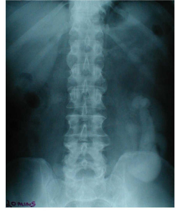

In [148]:
# load image
example = test_data["train"][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [149]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

axial ct scan showing a large mass of the right kidney.


In [150]:
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x708>,
 'Unnamed: 0': 7863,
 'id': 'ROCO_78739',
 'caption': ' 20-minute film of intravenous urography shows crossed, fused renal ectopia in the left ilio-lumbar region.\n'}

In [145]:
train_dataset[0]

{'input_ids': tensor([  101,  7978,  2203, 19137,  3630, 14773,  3746,  1006,  1021,  1012,
          1019, 11413,  1007,  1997,  1996,  2168,  1006, 20965,  1012,  1017,
          1007,  5776,  1012,  1044, 22571,  8913,  9905,  2594,  3742, 17657,
          1996,  6829,  4181,  2819,  1012, 11792,  1044, 22571,  8913,  9905,
          2594,  3164,  1048, 24335,  8458, 14164,  2024,  2036,  2556,  1012,
          2482, 21081,  2863,  1997,  1996, 23713, 22187,  1997, 12436,  3334,
          1024,  1056,  2509,  2078,  2487,  1012,  1006, 21469,  1024,  6829,
          4181,  2389, 11320,  3549,  1010,  1056,  1024, 10722, 20360,  3742,
          1010,  1048,  2078,  1024, 18804, 16677,  1048, 24335,  8458, 14164,
          1007,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [143]:
example = test_dataset[0]



tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         ...,
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

        [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         ...,
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

        [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

In [ ]:
from os import listdir
from keras.applications.vgg16 import preprocess_input

def load_photos(directory):
	images = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(400, 600))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get image id
		image_id = name.split('.')[0]
		images[image_id] = image
	return images

# load images
images = load_photos(image_folder)
print('Loaded Images: %d' % len(images))

In [ ]:
from keras.applications.vgg16 import VGG16
# load the model
in_layer = tf.keras.Input(shape=(400, 600, 3))
model = VGG16(include_top=False, input_tensor=in_layer, pooling='avg')
# print(model.summary())